<a href="https://colab.research.google.com/github/YangchenHuang/Algorithmic_Trading/blob/master/RL_Evolution%20Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=c5b6fad08240c4cd10d76e43ad2726fc1206fd6d15e9e95f2f3501b7c958cb15
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization

In [3]:
!rm -rf Algorithmic_Trading
!git clone https://github.com/YangchenHuang/Algorithmic_Trading

Cloning into 'Algorithmic_Trading'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
df = pd.read_csv('./Algorithmic_Trading/dataset/NVDA.csv')
df.head()

,PERMNO,date,VOL,NUMTRD,PRC,OPENPRC
0,86580,1/3/2007,19273722,67875,24.053333,24.713333
1,86580,1/4/2007,15957279,53389,23.940000,23.966667
2,86580,1/5/2007,20729060,75741,22.440000,23.373333
3,86580,1/8/2007,10955217,43714,22.606667,22.520000
4,86580,1/9/2007,12750524,48630,22.166667,22.640000


In [0]:
data = df[['PRC', 'VOL', 'OPENPRC', 'NUMTRD']].to_numpy().flatten()
data = data.tolist()
close = df['PRC'].tolist()
window_size = 30
skip = 5
l = len(close) - 1
test_size=l//4
dev_size=0

In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d*4 : (t + 1)*4] if d >= 0 else -d * [data[0], data[1], data[2], data[3]] + data[0 : (t + 1)*4]
    res = []
    for i in range(n - 1):
        for j in range(4):
            if block[i*4+j]==0:
                res.append(0)
            else:
                res.append((block[(i + 1)*4+j] - block[i*4+j])/block[i*4+j])
    return np.array([res])

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate, validate, buy, model
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.fsigma = sigma
        self.validate = validate
        self.buy = buy
        self.model=model

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        reward_list=[]
        max_validate=0
        best_model=self.model
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            # for k in range(self.population_size):
            #     if rewards[k]>0:
            #         self.siglist[k] = np.clip(self.sigma*(rmax-rewards[k])/rran, 0.00001*self.sigma, self.sigma)
            #     if rewards[k]<=0:
            #         self.siglist[k]=self.sigma
            # print(self.siglist)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    * np.dot(A.T, rewards).T
                )
            final_reward=self.reward_function(self.weights)
            if i>0:
                if final_reward>max(reward_list):
                    self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.95, 0.999)
                if final_reward<np.average(reward_list):
                    self.sigma=min(self.sigma*np.clip(np.average(reward_list)/(np.average(reward_list)-final_reward+1e-10),1.001, 1.05),min(2*self.fsigma, 0.99))
                # if final_reward<reward_list[i-1]:
                #     self.sigma=np.clip(self.sigma*(reward_list[i-1])/(final_reward-reward_list))
            reward_list.append(final_reward)
            # v=self.validate()
            # if (i + 1) % print_every == 0:
            #     print(
            #         'iter %d. reward: %f validate: %f %%'
            #         % (i + 1, final_reward, v)
            #     )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, final_reward)
                )
                self.buy()
            # if v > max_validate:
            #     best_model.set_weights=self.weights
            if i==epoch-1:
                self.buy()
            
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size)*0.01,
            np.random.randn(layer_size, output_size)*0.01,
            np.random.randn(layer_size+1, 1)*0.01,
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
            np.zeros((1,1))
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-3]
        a1=np.tanh(feed)
        decision = np.dot(a1, self.weights[1]) + self.weights[-2]
        z = np.append(np.argmax(decision[0]), a1)
        trade = np.dot(z, self.weights[2]) + self.weights[-1]
        return decision, trade

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
            self.validate,
            self.buy,
            self.model
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(data, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        # final_money = starting_money
        for t in range(30, l-test_size-dev_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money

            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size-dev_size-1]
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def validate(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(l-dev_size-test_size, l-test_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size]
        return ((initial_money - starting_money) / starting_money) * 100


    def buy(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        now_money = initial_money
        pnl=[]
        # final_money = starting_money
        for t in range(l-test_size, l, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
                states_sell.append(t)
                print(
                    'day %d, sell %d units at price %f, total balance %f,'
                    % (t, sell_units, total_sell, initial_money)
                )
            now_money=initial_money+quantity*close[t]
            pnl.append(((now_money - starting_money) / starting_money) * 100)
            state = next_state
        invest = ((now_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()
        plt.figure(figsize = (20, 10))
        plt.plot(pnl, label = 'pnl', c = 'r')

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size*4, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        100000,
        skip,
        window_size,
    )
    agent.fit(5, 5)
    return agent.es.reward_function(agent.es.weights)

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size))*4,
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [0]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (7, 90),
        'skip': (1, 7),
        'population_size': (1, 150),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 308, 'skip': 6, 'population_size': 135, 'sigma': 0.5005567900865452, 'learning_rate': 0.2327320663695231, 'size_network': 657}


KeyboardInterrupt: ignored

iter 1. reward: 0.011513
day 2305: buy 1 units at price 32.750000, total balance 99967.250000
day 2345, sell 1 units at price 37.310000, total balance 100004.560000,
day 2465: buy 1 units at price 65.610000, total balance 99938.950000
day 2525: buy 1 units at price 103.440000, total balance 99835.510000
day 2545, sell 2 units at price 227.240000, total balance 100062.750000,
day 2745: buy 1 units at price 214.140000, total balance 99848.610000
day 2765: buy 1 units at price 197.440000, total balance 99651.170000
day 2805, sell 2 units at price 491.859980, total balance 100143.029980,

total gained 143.029980, total investment 0.143030 %


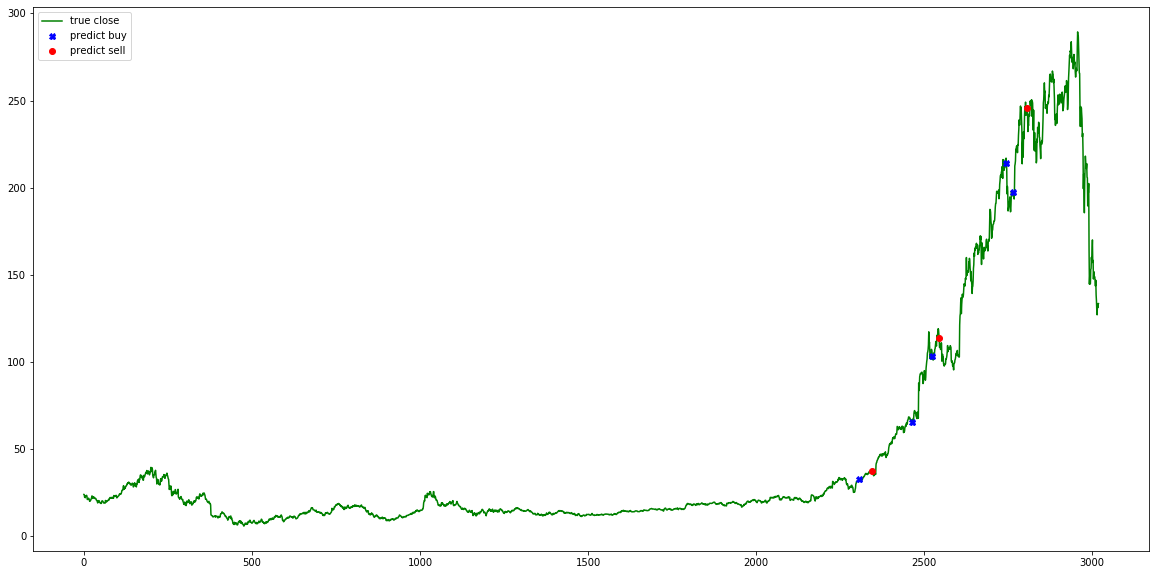

iter 2. reward: 0.004020
day 2305: buy 1 units at price 32.750000, total balance 99967.250000
day 2325, sell 1 units at price 35.760000, total balance 100003.010000,
day 2745: buy 1 units at price 214.140000, total balance 99788.870000
day 2765: buy 1 units at price 197.440000, total balance 99591.430000
day 2805, sell 2 units at price 491.859980, total balance 100083.289980,
day 2825: buy 1 units at price 232.970000, total balance 99850.319980
day 2845, sell 1 units at price 223.880000, total balance 100074.199980,

total gained 74.199980, total investment 0.074200 %


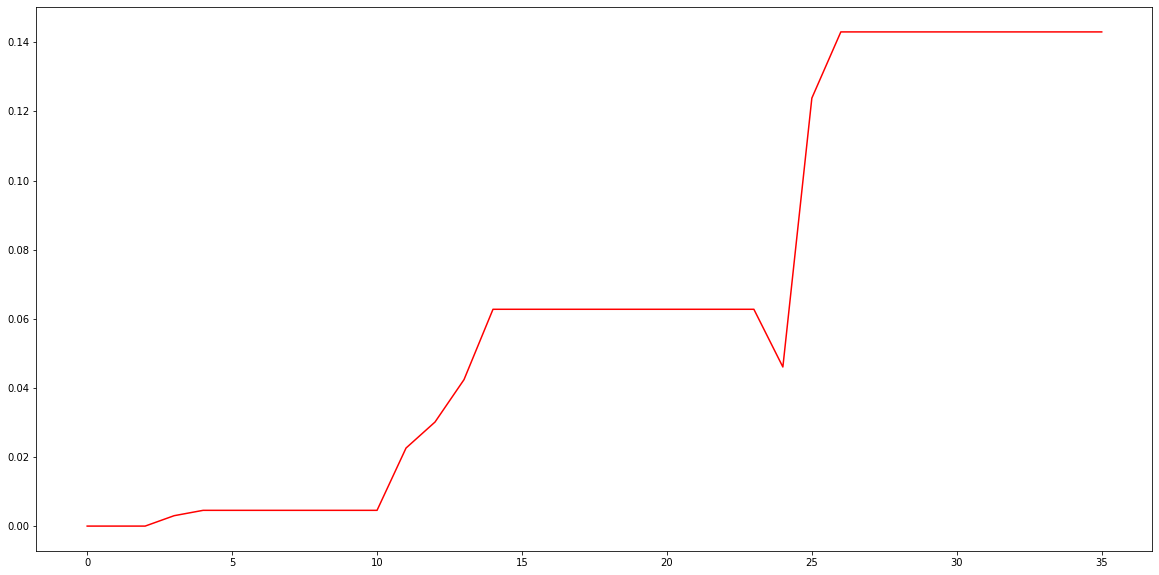

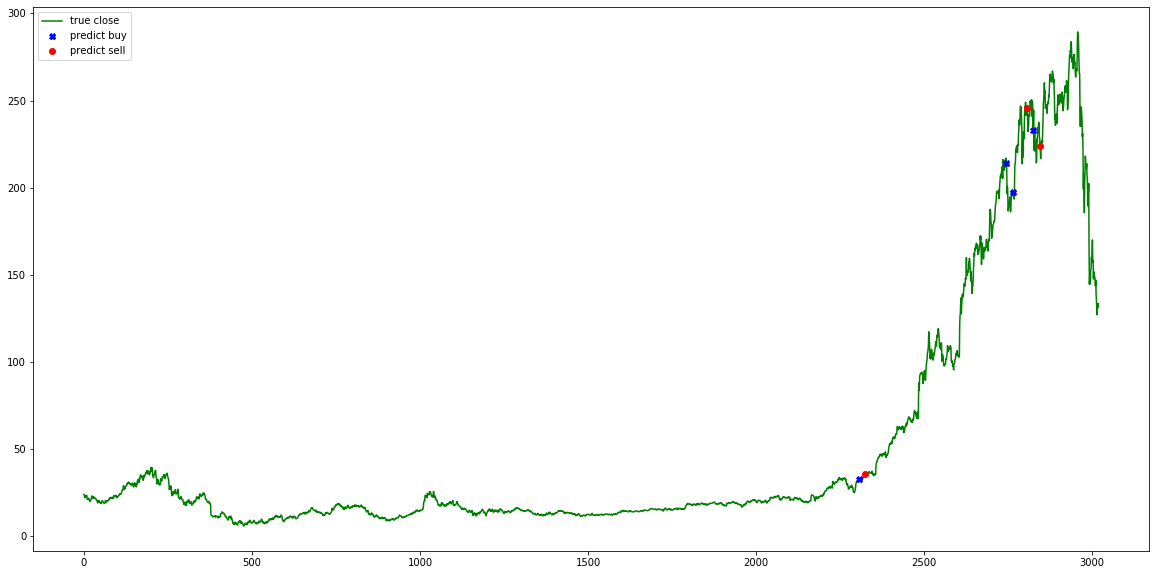

iter 3. reward: 0.053290
day 2265: buy 1 units at price 32.960000, total balance 99967.040000
day 2285: buy 1 units at price 29.300000, total balance 99937.740000
day 2305: buy 3 units at price 98.250000, total balance 99839.490000
day 2325: buy 1 units at price 35.760000, total balance 99803.730000
day 2345, sell 6 units at price 223.860000, total balance 100027.590000,
day 2465: buy 1 units at price 65.610000, total balance 99961.980000
day 2485, sell 1 units at price 83.640000, total balance 100045.620000,
day 2545: buy 1 units at price 113.620000, total balance 99932.000000
day 2585, sell 1 units at price 97.770000, total balance 100029.770000,
day 2745: buy 1 units at price 214.140000, total balance 99815.630000
day 2765: buy 1 units at price 197.440000, total balance 99618.190000
day 2805, sell 2 units at price 491.859980, total balance 100110.049980,
day 2845: buy 3 units at price 671.640000, total balance 99438.409980
day 2865, sell 3 units at price 732.720030, total balance 10

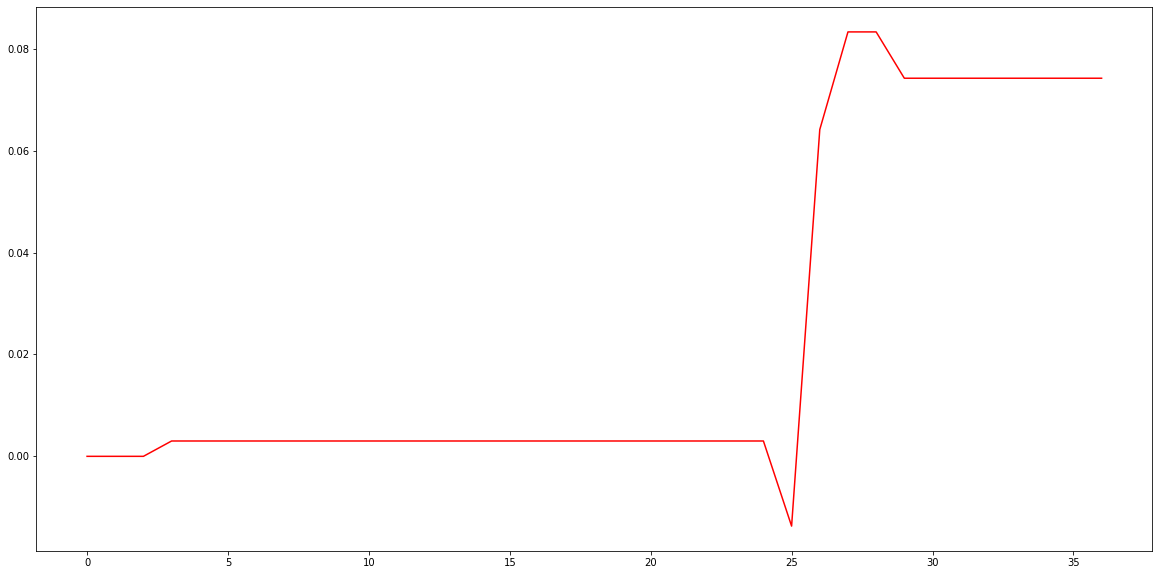

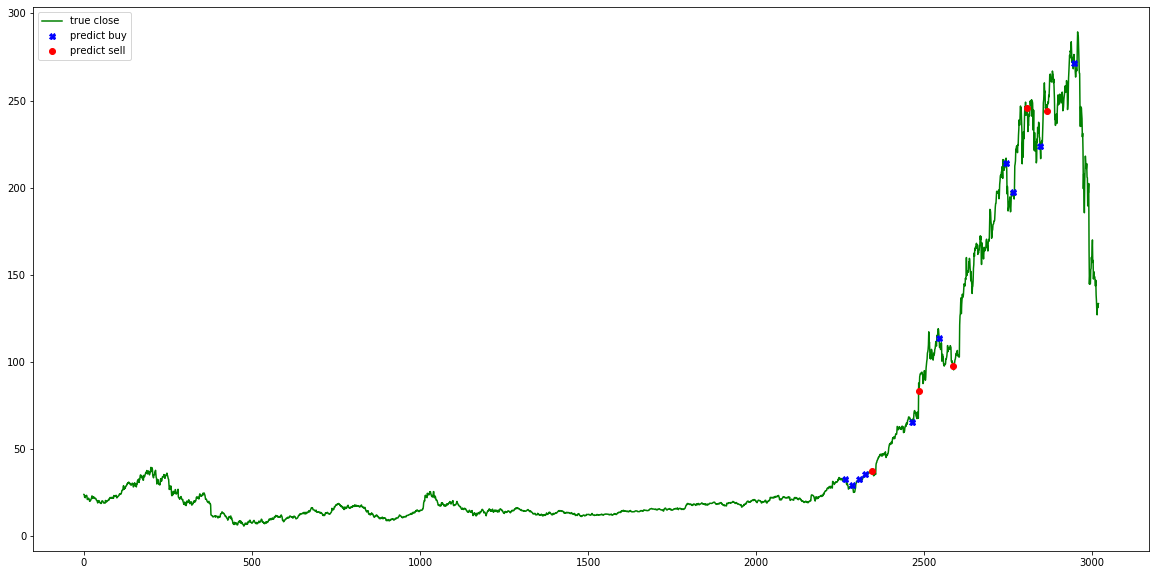

iter 4. reward: 0.124833
day 2265: buy 1 units at price 32.960000, total balance 99967.040000
day 2285: buy 1 units at price 29.300000, total balance 99937.740000
day 2305: buy 9 units at price 294.750000, total balance 99642.990000
day 2325: buy 1 units at price 35.760000, total balance 99607.230000
day 2345, sell 12 units at price 447.720000, total balance 100054.950000,
day 2545: buy 3 units at price 340.860000, total balance 99714.090000
day 2565: buy 1 units at price 101.850000, total balance 99612.240000
day 2605, sell 4 units at price 411.760000, total balance 100024.000000,
day 2625: buy 1 units at price 149.120000, total balance 99874.880000
day 2665, sell 1 units at price 166.480000, total balance 100041.360000,
day 2745: buy 1 units at price 214.140000, total balance 99827.220000
day 2765: buy 1 units at price 197.440000, total balance 99629.780000
day 2805, sell 2 units at price 491.859980, total balance 100121.639980,
day 2825: buy 1 units at price 232.970000, total balanc

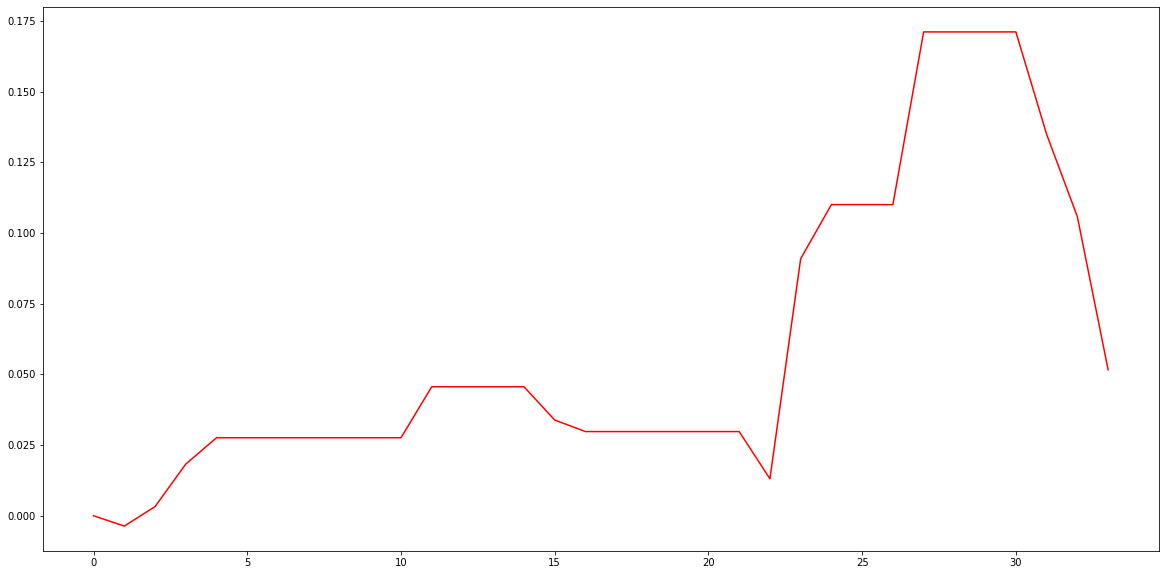

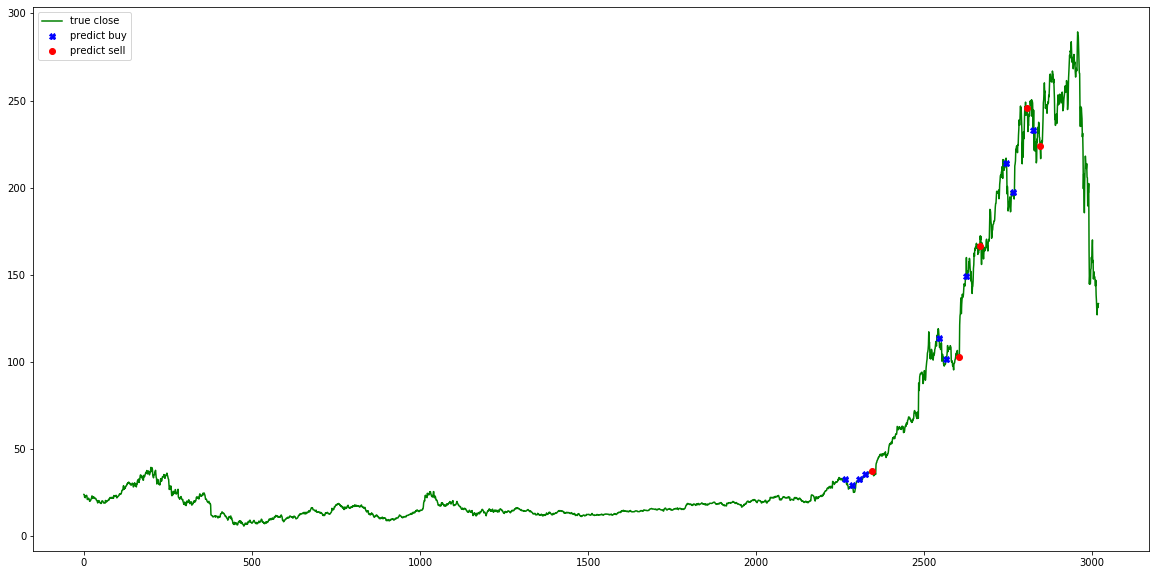

iter 5. reward: 0.391157
day 2265: buy 2 units at price 65.920000, total balance 99934.080000
day 2285: buy 1 units at price 29.300000, total balance 99904.780000
day 2305: buy 12 units at price 393.000000, total balance 99511.780000
day 2325: buy 9 units at price 321.840000, total balance 99189.940000
day 2345: buy 6 units at price 223.860000, total balance 98966.080000
day 2465, sell 30 units at price 1968.300000, total balance 100934.380000,
day 2525: buy 13 units at price 1344.720000, total balance 99589.660000
day 2565: buy 2 units at price 203.700000, total balance 99385.960000
day 2745: buy 2 units at price 428.280000, total balance 98957.680000
day 2825: buy 2 units at price 465.940000, total balance 98491.740000
day 2885, sell 19 units at price 4943.230190, total balance 103434.970190,

total gained 3434.970190, total investment 3.434970 %


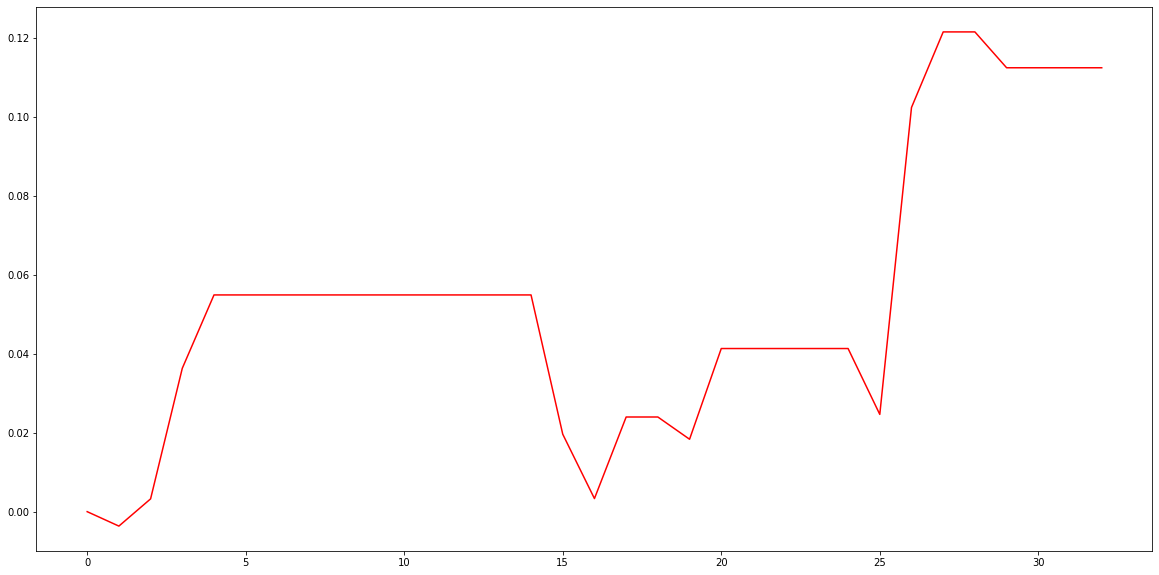

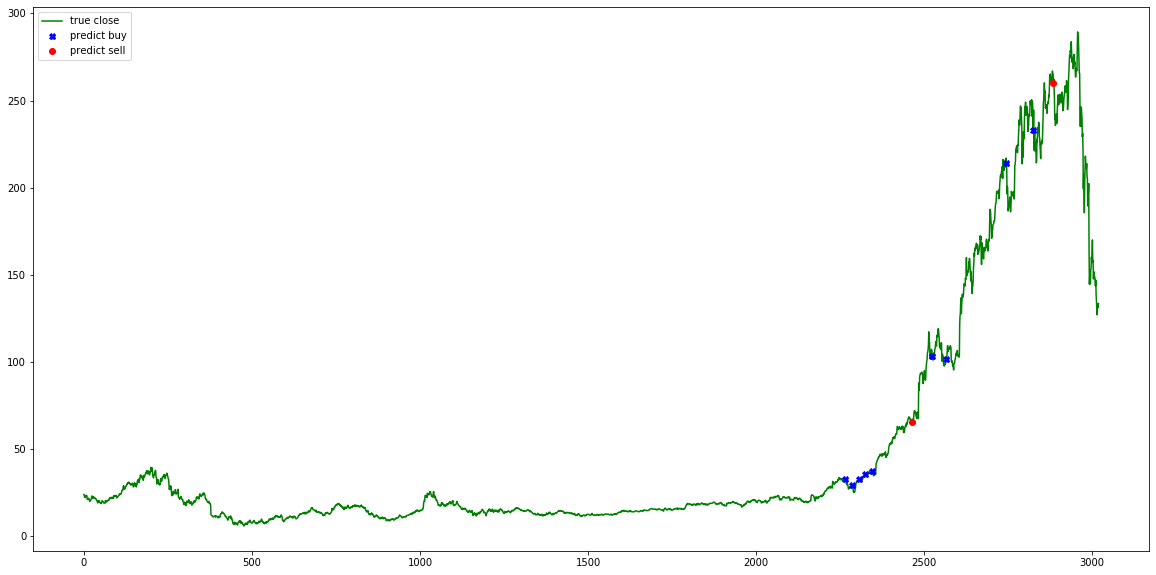

day 2265: buy 2 units at price 65.920000, total balance 99934.080000
day 2285: buy 1 units at price 29.300000, total balance 99904.780000
day 2305: buy 12 units at price 393.000000, total balance 99511.780000
day 2325: buy 9 units at price 321.840000, total balance 99189.940000
day 2345: buy 6 units at price 223.860000, total balance 98966.080000
day 2465, sell 30 units at price 1968.300000, total balance 100934.380000,
day 2525: buy 13 units at price 1344.720000, total balance 99589.660000
day 2565: buy 2 units at price 203.700000, total balance 99385.960000
day 2745: buy 2 units at price 428.280000, total balance 98957.680000
day 2825: buy 2 units at price 465.940000, total balance 98491.740000
day 2885, sell 19 units at price 4943.230190, total balance 103434.970190,

total gained 3434.970190, total investment 3.434970 %


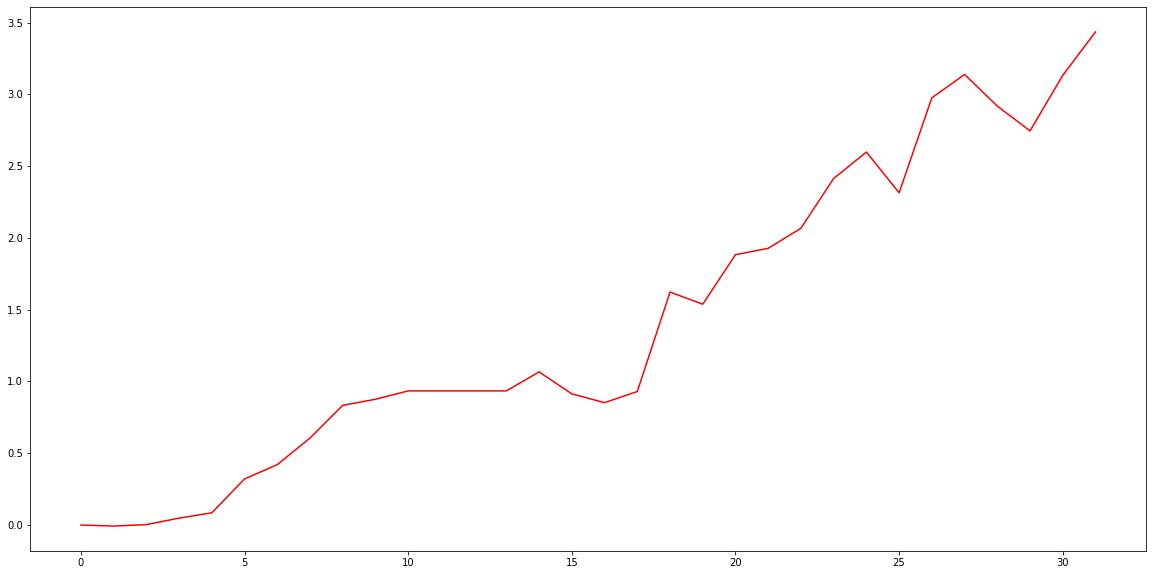

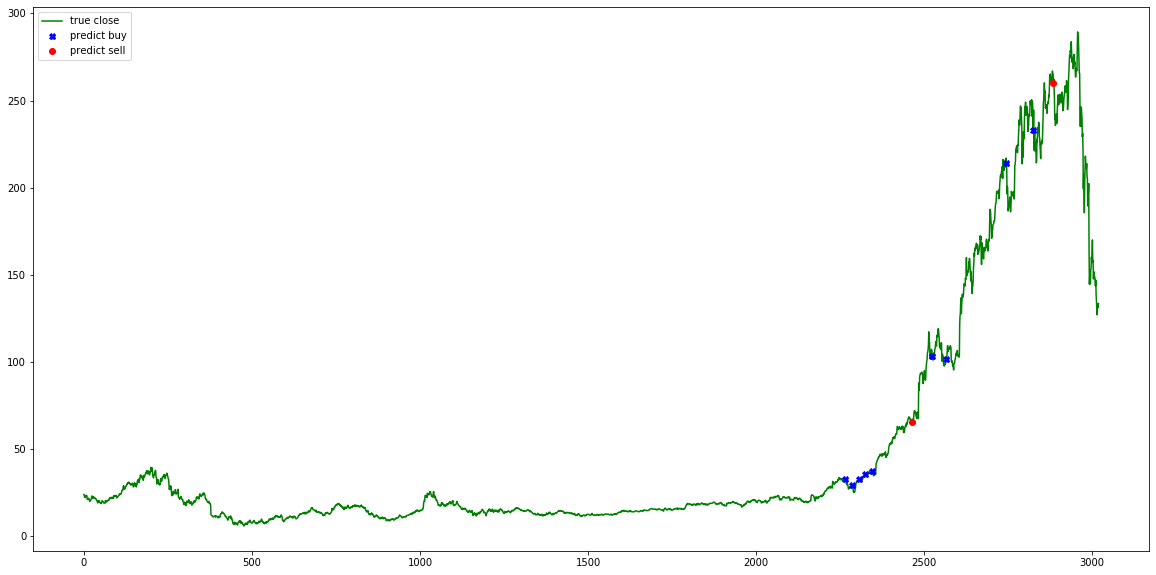

time taken to train: 11.31793475151062 seconds


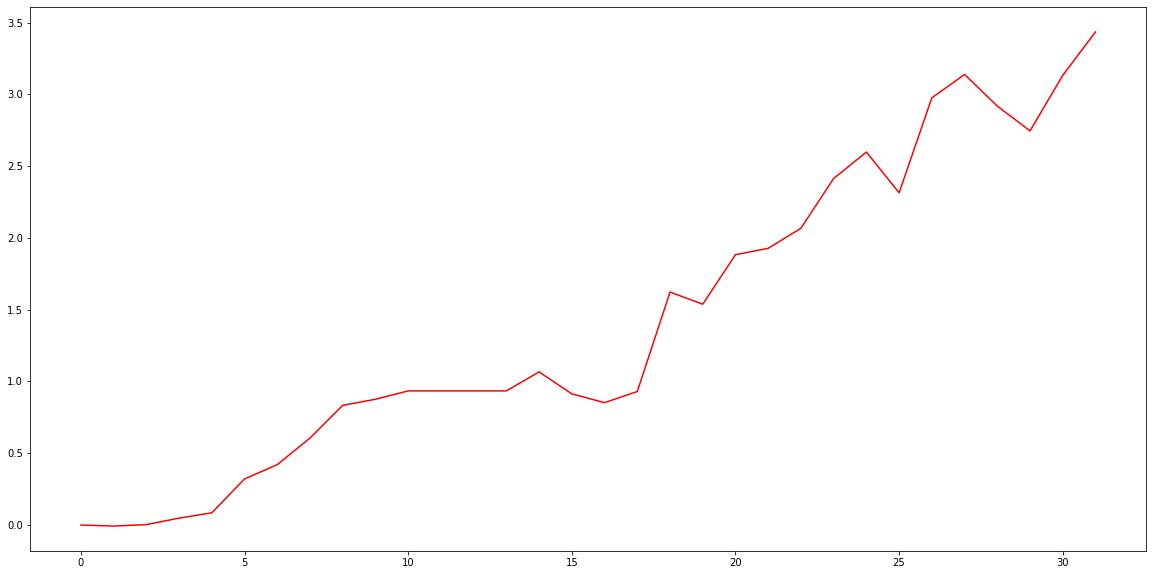

In [13]:
model = Model(input_size = 30*4, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 50, 
              sigma = 0.1, 
              learning_rate = 0.02, 
              model = model, 
              money = 100000,  
              skip = 20, 
              window_size = 30)
agent.fit(5, 1)

In [0]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size']))*4, 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 100000, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)